In [1]:
import pandas as pd
import glob
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import pacf

E:\Informatika\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
E:\Informatika\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
df = pd.read_csv("../input/wind_dataset_imputed_and_scaled1.csv")
df['DATE']=pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df.head()

,WIND,RAIN,T.MAX,T.MIN,T.MIN.G,IND_0,IND_1,IND_4,IND.1_0.0,IND.1_1.0,IND.1_2.0,IND.1_4.0,IND.2_0.0,IND.2_1.0,IND.2_2.0,IND.2_3.0,IND.2_4.0
DATE,,,,,,,,,,,,,,,,,
1961-01-01,0.450115,0.002985,0.356877,0.515254,0.443709,1,0,0,1,0,0,0,1,0,0,0,0
1961-01-02,0.378663,0.076119,0.271375,0.532203,0.513245,1,0,0,1,0,0,0,1,0,0,0,0
1961-01-03,0.370431,0.005970,0.208178,0.406780,0.460265,1,0,0,1,0,0,0,1,0,0,0,0
1961-01-04,0.284162,0.002985,0.211896,0.403390,0.370861,1,0,0,1,0,0,0,1,0,0,0,0
1961-01-05,0.392493,0.155224,0.271375,0.338983,0.228477,1,0,0,1,0,0,0,0,1,0,0,0


In [3]:
train_df, test_df = train_test_split(df, test_size=0.3, shuffle=False)

In [4]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [5]:
n_past = 5
n_future = 1
n_features = 17

In [6]:
X_train, y_train = split_series(train_df.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))[:,0,0]

X_test, y_test = split_series(test_df.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))[:,0,0]

In [7]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Bidirectional

### real data

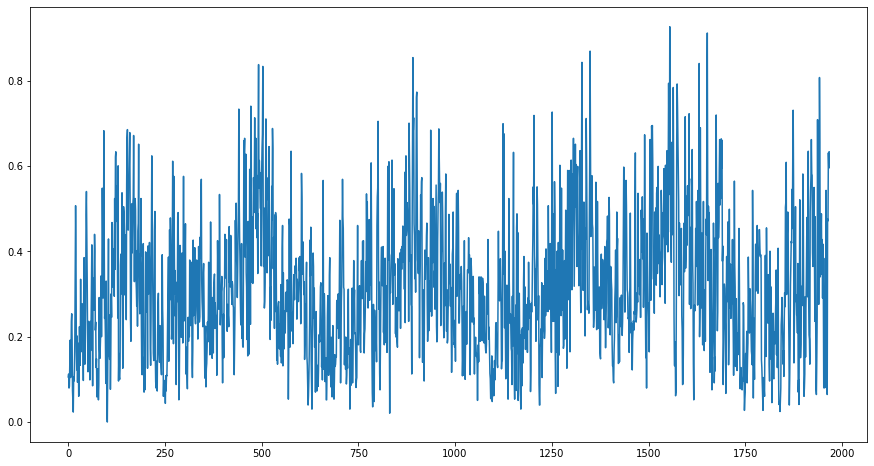

In [8]:
plt.figure(figsize=(15,8))
plt.plot(y_test)

### Vanilla LSTM

In [9]:
model_vanilla = Sequential()
model_vanilla.add(LSTM(50, activation='relu', input_shape=(n_past, n_features)))
model_vanilla.add(Dense(1))
model_vanilla.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                13600     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 13,651
Trainable params: 13,651
Non-trainable params: 0
_________________________________________________________________


In [10]:
model_vanilla.compile(loss='mse',optimizer='adam', metrics=[tf.metrics.MeanAbsoluteError()])
model_vanilla.fit(X_train,y_train,epochs=25,batch_size=32,verbose=0)
pred_vanilla=model_vanilla.predict(X_test)

62/62 [==============================] - 0s 2ms/step


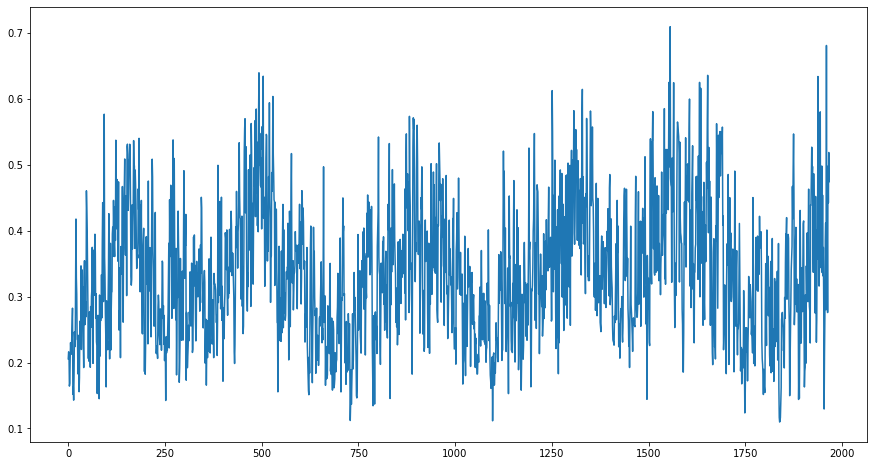

In [11]:
plt.figure(figsize=(15,8))
plt.plot(pred_vanilla)

In [12]:
mean_absolute_error(pred_vanilla,y_test)

0.0999373890028959

### 2 stacked LSTM

In [13]:
model_2stacked = Sequential()
model_2stacked.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_past, n_features)))
model_2stacked.add(LSTM(50, activation='relu'))
model_2stacked.add(Dense(1))

In [14]:
model_2stacked.compile(loss='mse',optimizer='adam', metrics=[tf.metrics.MeanAbsoluteError()])
model_2stacked.fit(X_train,y_train,epochs=25,batch_size=32,verbose=0)
pred_2stacked=model_2stacked.predict(X_test)

62/62 [==============================] - 0s 2ms/step


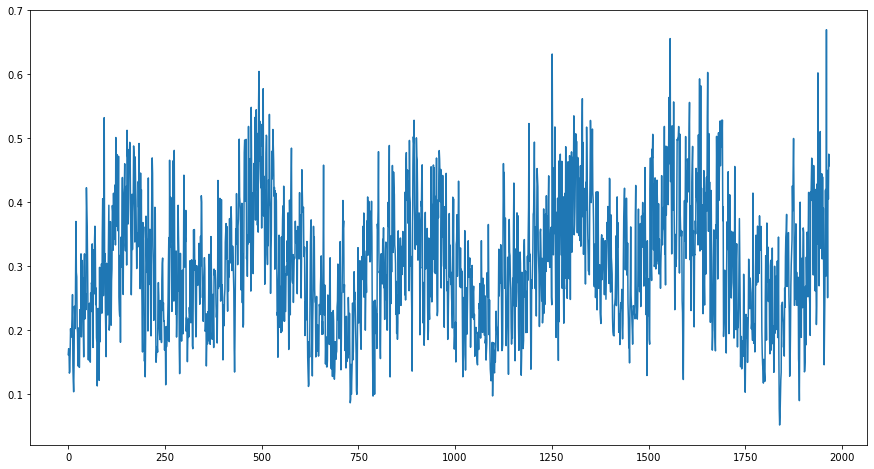

In [15]:
plt.figure(figsize=(15,8))
plt.plot(pred_2stacked)

In [16]:
mean_absolute_error(pred_2stacked,y_test)

0.09767589605957563

### 3 stacked LSTM

In [17]:
model_3stacked = Sequential()
model_3stacked.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_past, n_features)))
model_3stacked.add(LSTM(50, activation='relu', return_sequences=True))
model_3stacked.add(LSTM(50, activation='relu'))
model_3stacked.add(Dense(1))

In [18]:
model_3stacked.compile(loss='mse',optimizer='adam', metrics=[tf.metrics.MeanAbsoluteError()])
model_3stacked.fit(X_train,y_train,epochs=25,batch_size=32,verbose=0)
pred_3stacked=model_3stacked.predict(X_test)

62/62 [==============================] - 1s 4ms/step


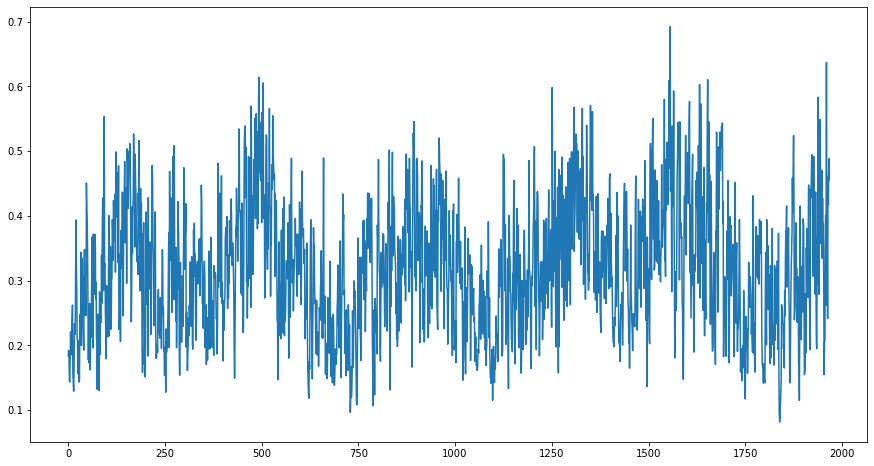

In [19]:
plt.figure(figsize=(15,8))
plt.plot(pred_3stacked)

In [20]:
mean_absolute_error(pred_3stacked,y_test)

0.09812593525895215

### bidirectional LSTM

In [21]:
model_bidirectional = Sequential()
model_bidirectional.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_past, n_features)))
model_bidirectional.add(Dense(1))

In [22]:
model_bidirectional.compile(loss='mse',optimizer='adam', metrics=[tf.metrics.MeanAbsoluteError()])
model_bidirectional.fit(X_train,y_train,epochs=25,batch_size=32,verbose=0)
pred_bidirectional=model_bidirectional.predict(X_test)

62/62 [==============================] - 0s 2ms/step


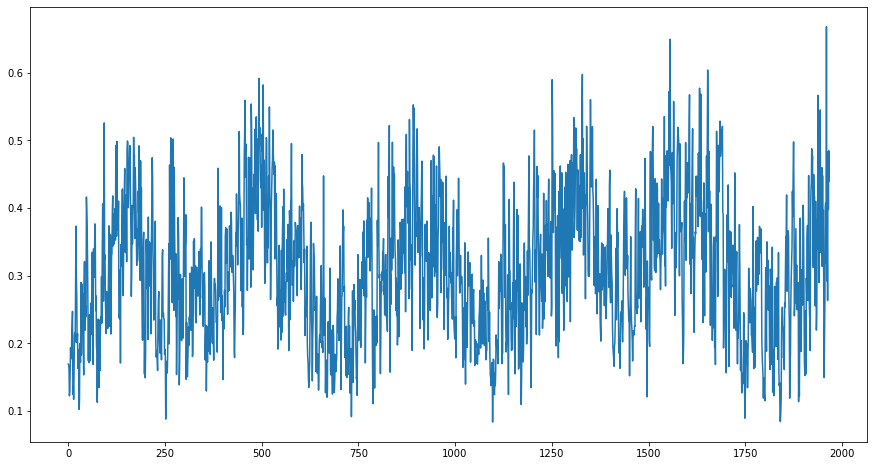

In [23]:
plt.figure(figsize=(15,8))
plt.plot(pred_bidirectional)

In [24]:
mean_absolute_error(pred_bidirectional,y_test)

0.09718611524198226

### CNN LSTM

In [25]:
n_past_CNN = 4
n_seq = 2

X_train_CNN, y_train_CNN = split_series(train_df.values,n_past_CNN, n_future)
X_train_CNN = X_train_CNN.reshape((X_train_CNN.shape[0], int(X_train_CNN.shape[1]/2),n_seq, n_features))
y_train_CNN = y_train_CNN.reshape((y_train_CNN.shape[0], y_train_CNN.shape[1], n_features))[:,0,0]

X_test_CNN, y_test_CNN = split_series(test_df.values,n_past_CNN, n_future)
X_test_CNN = X_test_CNN.reshape((X_test_CNN.shape[0], int(X_test_CNN.shape[1]/2),n_seq, n_features))
y_test_CNN = y_test_CNN.reshape((y_test_CNN.shape[0], y_test_CNN.shape[1], n_features))[:,0,0]

In [26]:
model_CNN = Sequential()
model_CNN.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(2, 2, n_features)))
model_CNN.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_CNN.add(TimeDistributed(Flatten()))
model_CNN.add(LSTM(50, activation='relu'))
model_CNN.add(Dense(1))

In [27]:
model_CNN.compile(loss='mse',optimizer='adam', metrics=[tf.metrics.MeanAbsoluteError()])
model_CNN.fit(X_train_CNN,y_train_CNN,epochs=25,batch_size=32,verbose=0)
pred_CNN=model_CNN.predict(X_test_CNN)

62/62 [==============================] - 0s 2ms/step


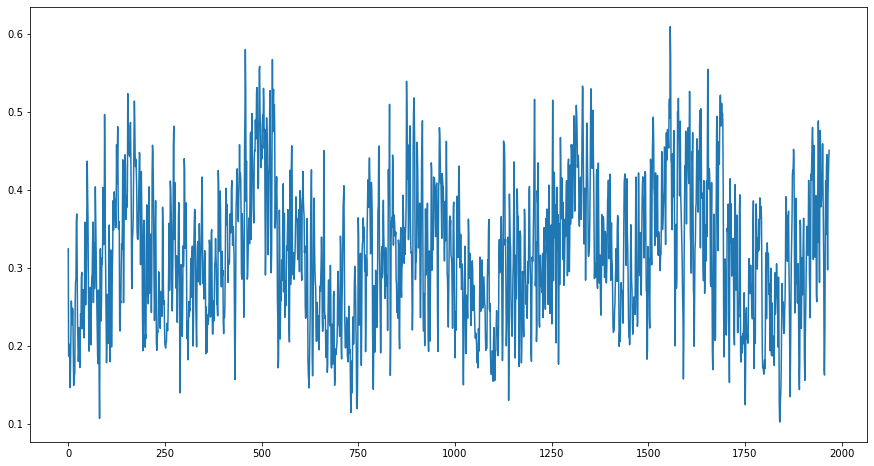

In [28]:
plt.figure(figsize=(15,8))
plt.plot(pred_CNN)

In [29]:
mean_absolute_error(pred_CNN,y_test_CNN)

0.1056447837887347

### Encoder-Decoder Model

In [30]:
X_train_ed, y_train_ed = split_series(train_df.values,n_past, n_future)
X_train_ed = X_train_ed.reshape((X_train_ed.shape[0], X_train_ed.shape[1], n_features))
y_train_ed = y_train_ed.reshape((y_train_ed.shape[0], y_train_ed.shape[1], n_features))

X_test_ed, y_test_ed = split_series(test_df.values,n_past, n_future)
X_test_ed = X_test_ed.reshape((X_test_ed.shape[0], X_test_ed.shape[1], n_features))
y_test_ed = y_test_ed.reshape((y_test_ed.shape[0], y_test_ed.shape[1], n_features))

In [31]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(64, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

decoder_l1 = tf.keras.layers.LSTM(64, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

In [32]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e1d1.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
model_e1d1.fit(X_train_ed,y_train_ed,epochs=25,batch_size=32,verbose=0,callbacks=[reduce_lr])
pred_e1d1=model_e1d1.predict(X_test_ed)

62/62 [==============================] - 1s 2ms/step


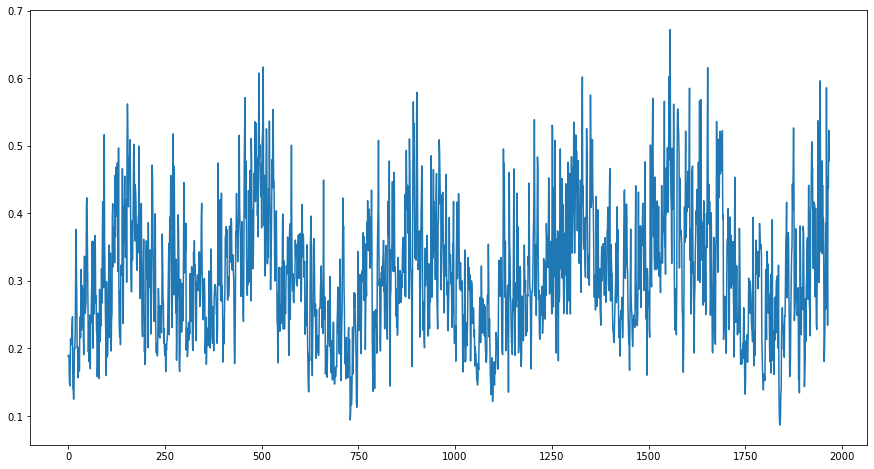

In [33]:
plt.figure(figsize=(15,8))
plt.plot(pred_e1d1[:,0,0])

In [34]:
mean_absolute_error(pred_e1d1[:,0,0],y_test)

0.09938858687769064

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/